In [3]:
pip install tensorflow numpy matplotlib PILLOW

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Content image saved as 'content.jpg'.
Style image saved as 'style.jpg'.


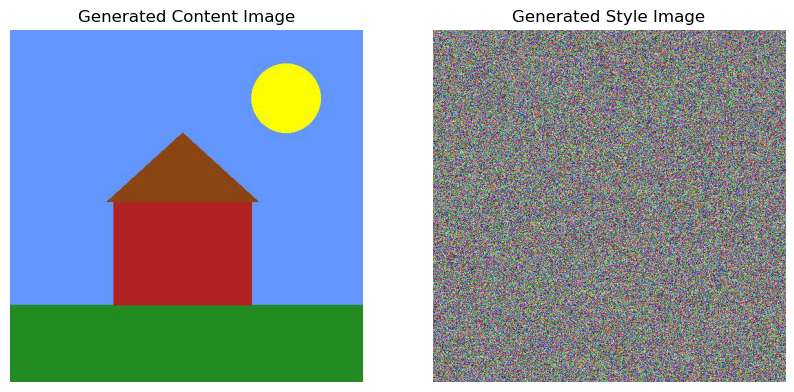

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# Function to create a simple content image
def create_content_image():
    img = Image.new("RGB", (512, 512), color=(100, 150, 255))  # Sky blue background
    draw = ImageDraw.Draw(img)
    
    # Draw a sun
    draw.ellipse((350, 50, 450, 150), fill=(255, 255, 0))  # Yellow sun
    
    # Draw some grass
    draw.rectangle((0, 400, 512, 512), fill=(34, 139, 34))  # Green grass
    
    # Draw a house
    draw.rectangle((150, 250, 350, 400), fill=(178, 34, 34))  # Red house
    draw.polygon([(140, 250), (250, 150), (360, 250)], fill=(139, 69, 19))  # Roof

    img.save("content.jpg")
    print("Content image saved as 'content.jpg'.")

# Function to create an abstract style image
def create_style_image():
    img = np.random.rand(512, 512, 3) * 255  # Random noise
    img = img.astype(np.uint8)
    img = Image.fromarray(img)
    img.save("style.jpg")
    print("Style image saved as 'style.jpg'.")

# Generate and save images
create_content_image()
create_style_image()

# Show generated images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(Image.open("content.jpg"))
ax1.set_title("Generated Content Image")
ax1.axis("off")

ax2.imshow(Image.open("style.jpg"))
ax2.set_title("Generated Style Image")
ax2.axis("off")

plt.show()

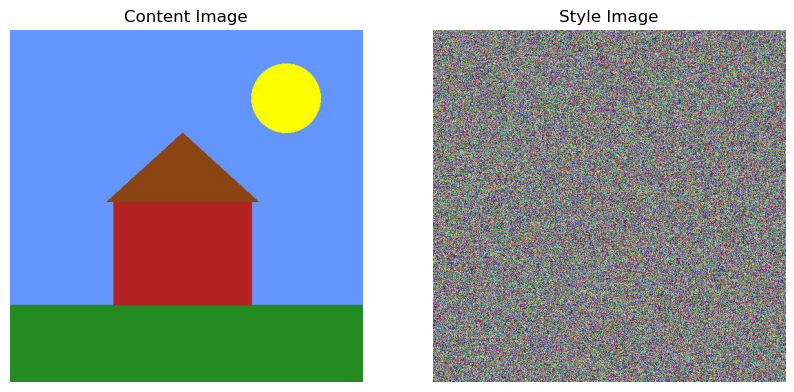

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step
Iteration 0: Loss = 8.10528017439785e+17


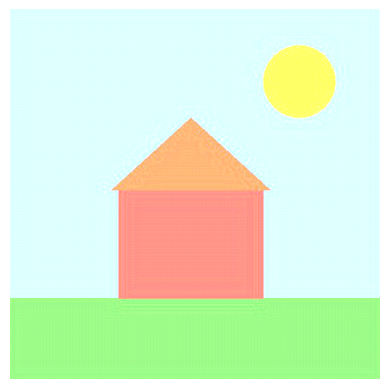

Iteration 50: Loss = 1.0067572993032192e+16


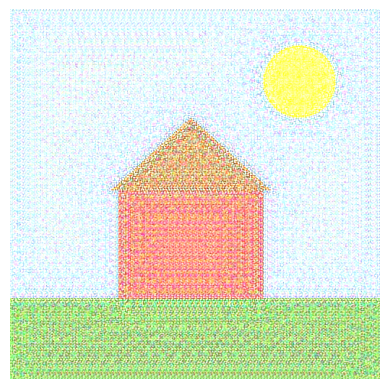

Iteration 100: Loss = 2542223623192576.0


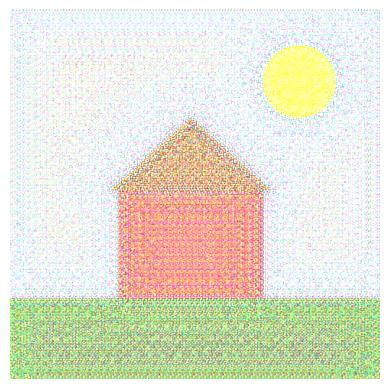

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
from tensorflow.keras.applications import vgg19

# Function to load and preprocess the image
def load_image(image_path, max_dim=512):
    img = PIL.Image.open(image_path)
    img = img.resize((max_dim, max_dim), PIL.Image.LANCZOS)
    img = np.array(img, dtype=np.float32)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

# Function to deprocess image (convert back to RGB format)
def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]  # Convert BGR to RGB
    img = np.clip(img, 0, 255).astype("uint8")
    return img

# Load content and style images
content_path = "content.jpg"
style_path = "style.jpg"

content_image = load_image(content_path)
style_image = load_image(style_path)

# Display the images
def show_images(content, style):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(deprocess_image(content))
    ax1.set_title("Content Image")
    ax1.axis("off")

    ax2.imshow(deprocess_image(style))
    ax2.set_title("Style Image")
    ax2.axis("off")

    plt.show()

show_images(content_image, style_image)

# Define a VGG19 model for feature extraction
def get_model():
    vgg = vgg19.VGG19(weights="imagenet", include_top=False)
    vgg.trainable = False
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    content_layers = ['block4_conv2']
    model_outputs = [vgg.get_layer(name).output for name in (content_layers + style_layers)]
    return tf.keras.Model([vgg.input], model_outputs)

# Extract features
model = get_model()

# Compute content loss
def compute_content_loss(content, generated):
    return tf.reduce_mean(tf.square(content - generated))

# Compute style loss using Gram Matrix
def gram_matrix(tensor):
    channels = int(tensor.shape[-1])
    a = tf.reshape(tensor, [-1, channels])
    gram = tf.matmul(a, a, transpose_a=True)
    return gram

def compute_style_loss(style, generated):
    return tf.reduce_mean(tf.square(gram_matrix(style) - gram_matrix(generated)))

# Define total loss function
def compute_total_loss(model, content_image, style_image, generated_image, content_weight=1e4, style_weight=1e-2):
    outputs = model(generated_image)
    content_outputs = outputs[:1]
    style_outputs = outputs[1:]

    content_loss = compute_content_loss(content_outputs[0], model(content_image)[:1][0])
    style_loss = sum([compute_style_loss(style, gen) for style, gen in zip(model(style_image)[1:], style_outputs)])

    total_loss = content_weight * content_loss + style_weight * style_loss
    return total_loss

# Perform Neural Style Transfer using optimization
generated_image = tf.Variable(content_image, dtype=tf.float32)

# Define optimizer
optimizer = tf.optimizers.Adam(learning_rate=5.0)

# Run the optimization
epochs = 500
for i in range(epochs):
    with tf.GradientTape() as tape:
        loss = compute_total_loss(model, content_image, style_image, generated_image)

    gradients = tape.gradient(loss, generated_image)
    optimizer.apply_gradients([(gradients, generated_image)])

    if i % 50 == 0:
        print(f"Iteration {i}: Loss = {loss.numpy()}")
        output_img = deprocess_image(generated_image.numpy())
        plt.imshow(output_img)
        plt.axis("off")
        plt.show()

# Save the final image
output_image = deprocess_image(generated_image.numpy())
PIL.Image.fromarray(output_image).save("styled_output.jpg")

plt.imshow(output_image)
plt.axis("off")
plt.show()

print("Neural Style Transfer complete! Styled image saved as 'styled_output.jpg'.")

In [2]:
!jupyter nbconvert --to pdf "Create and Art with Neural style transfer on given image using deep learning.ipynb"

This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern 'Create and Art with Neural style transfer on given image using deep learning.ipynb' matched no files
